# CIFAR10

DOWNLOAD DATA FROM [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) AND PUT IT TO THE DATA FOLDER

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

One can see state-of-the-art results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

In [1]:
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

# Data

Unarchive data

In [3]:
#!pwd

In [4]:
#!ls /root/shared/Dropbox/Projects/Courses/DataScienceAtScale/Assignments/HW-Assignment-SOLUTIONS/Unit-07-Logistic-Regression-CIFAR10/data/cifar-10-python.tar.gz

In [5]:
#tar = tarfile.open("/root/shared/Dropbox/Projects/Courses/DataScienceAtScale/Assignments/HW-Assignment-SOLUTIONS/Unit-07-Logistic-Regression-CIFAR10/data/cifar-10-python.tar.gz", "r:gz")
tar = tarfile.open("C:\\Users\\hjiang\\i526\\Assignment\\data\\cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Reading

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [6]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding="latin1")
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [22]:
for b in range(1, 6):
    data_batch = unpickle("C:\\Users\\hjiang\\i526\\Assignment\\data\\cifar-10-batches-py\\data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [23]:
data_batch = unpickle("C:\\Users\\hjiang\\i526\\Assignment\\data\\cifar-10-batches-py\\test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [24]:
classes = unpickle("C:\\Users\\hjiang\\i526\\Assignment\\data\\cifar-10-batches-py\\batches.meta")["label_names"]

## Pre-processing

We have too many data

In [25]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


Let's take only 10% of them to train faster

In [26]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [27]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The same for test

In [13]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 5000
Test size: 1000


Indeed, we preserved the number of objects of each class

In [36]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500),
 ('automobile', 500),
 ('bird', 500),
 ('cat', 500),
 ('deer', 500),
 ('dog', 500),
 ('frog', 500),
 ('horse', 500),
 ('ship', 500),
 ('truck', 500)]

## Visualization

For now each object has the following shape

In [18]:
X_train[0].shape

(3072,)

$3072 = 32 \times 32 \times 3$ where $32 \times 32$ is the size of the image in pixels and $3$ is the number of channels (RGB)

To show this array as an image let's reshape it in the needed from with the shape $(32, 32, 1)$

In [39]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

Draw one pic from each class

In [20]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

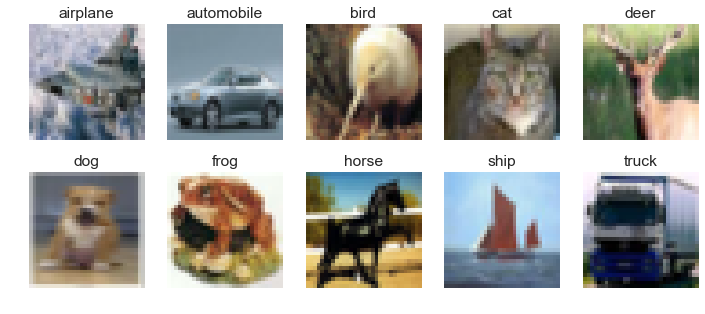

In [21]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

# Sklearn Logistic Regression

Let's use Sklearn implementation of algorithms to have a benchmark.

Also one should **always** track the results of the experiments to be able to compare different approaches. Let's create pandas $\text{DataFrame}$ for this purpose.

In [17]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

For now it is empty, but will be filled in later

In [18]:
results

,Model,Test Accuracy


## Defining model

Let's try Multinomial Logistic Regression (see theory in lectures)
Sklearn implementation of LogRegression implies mandatory usage of regularization (it almost always works better with it preventing overfitting). We want to explore very basic LogRegression model thus to "disable" regularization we need to reduce its impact to almost zero. It can be done by setting regularization constant $\lambda$ to very small value (in sklearn we define inverse regularization constant $C = 1 / \lambda$ thus we need to make it big)

Here we use Sklearn $\text{LogisticRegression}$ with few options:
* $\text{multi_class} = \text{"multinomial"} -$we want to build softmax classifier (there are other ways of dealing with multiclass setting for Logistic Regression)
* $\text{C} = 10^6-$ for now we don't want to use regularization; $\text{C}$ is the inverse regularization constant which is $\text{C} = \frac{1}{\lambda}$; thus we should make $\text{C}$ big to turn off regulazrization
* $\text{solver} = \text{sag} -$ optimization algorithm to use; Stochastic Average Gradient. Stochastic Gradient Descent method gitters massively. This is due to the not very good approximation of gradient (only by one example). To neglect this error one can simply average gradient across last few steps; that is exectly what $\text{sag}$ does
* $\text{max_iter} = 15 -$ the number of passes over the training data (aka epochs)

In [19]:
model_lr_sklearn = LogisticRegression(multi_class="multinomial", C=1e6, solver="sag", max_iter=15)

### Fitting

In [20]:
model_lr_sklearn.fit(X_train, y_train)

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=15,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

### Evaluation

Prediction

In [21]:
y_pred_test = model_lr_sklearn.predict(X_test)

Accuracy

In [22]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [23]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,LR Sklearn,0.358


Keeping table of results up-to-date

# Assignments begin here

# The Great Race

## BG: Part 1: Pima Diabetes classification

It is important to compare the performance of multiple different machine learning algorithms
consistently. In this chapter you will discover how you can create a test harness to compare
multiple different machine learning algorithms in Python with scikit-learn. You can use this
test harness as a template on your own machine learning problems and add more and different
algorithms to compare. After completing this lesson you will know:

1. How to formulate an experiment to directly compare machine learning algorithms.
2. A reusable template for evaluating the performance of multiple algorithms on one dataset.
3. How to report and visualize the results when comparing algorithm performance.

In the example below six different classification
algorithms (some of which you will recognize!) are compared on a single dataset:

*  Logistic Regression
*  Linear Discriminant Analysis
*  k-Nearest Neighbors
*  Classification and Regression Trees
*  Naive Bayes
* Support Vector Machines.

The dataset is the Pima Indians onset of diabetes problem. The problem has two classes and
eight numeric input variables of varying scales. The 10-fold cross-validation procedure is used to
evaluate each algorithm, importantly configured with the same random seed to ensure that the
same splits to the training data are performed and that each algorithm is evaluated in precisely
the same way. Each algorithm is given a short name, useful for summarizing results afterward.

### Cross-Validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [15]:
#e.g., 
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Next step is to do everything that we've done before in a loop:
* Split
* Train
* Evaluate

And store the average value of the accuracy. Running the code below provides a list of each "algorithm short name", the mean accuracy and the standard deviation accuracy.

LR: 0.769515 (0.048411)
LDA: 0.773462 (0.051592)
KNN: 0.726555 (0.061821)
CART: 0.686141 (0.055568)
NB: 0.755178 (0.042766)
SVM: 0.651025 (0.072141)


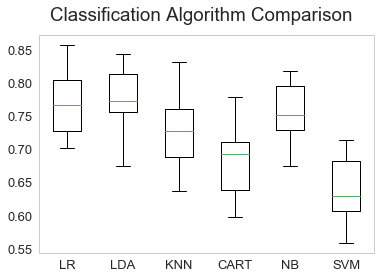

In [45]:
#

Above we produced a box and whisker plot showing the spread of the accuracy scores
across each cross-validation fold for each algorithm.

From these results, it would suggest that both logistic regression and linear discriminant
analysis are perhaps worthy of further study on this problem.

## Task: CIFAR10 Great Race 
Repeat the above RACE for the CIFAR10 dataset and draw some conclusions

LR: 0.222600 (0.012363)


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LDA: 0.176200 (0.016086)
KNN: 0.274600 (0.011526)
CART: 0.218400 (0.025009)
NB: 0.293200 (0.019904)
SVM: 0.079200 (0.006145)


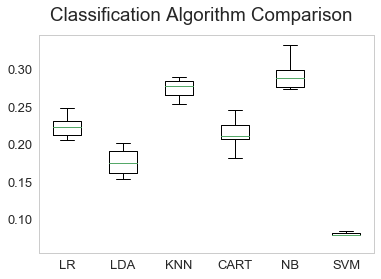

In [24]:
# Compare Algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
X=X_train
Y=y_train
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
#Standardize the data
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.grid()
pyplot.show()

From these results, it would suggest that both KNN and Gaussian Naive Bayes are perhaps worthy of further study on this problem.What shocked me is that SVM performance was so low.

** Let's see what is the difference if scaling data before training**

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


LR: 0.256000 (0.022943)


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LDA: 0.176200 (0.016086)
KNN: 0.278200 (0.015658)
CART: 0.212600 (0.022362)
NB: 0.293200 (0.019904)
SVM: 0.440600 (0.019961)


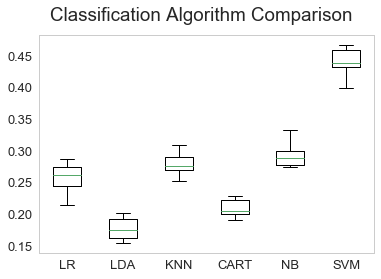

In [17]:
# Compare Algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#Standard scaling before training
scl= StandardScaler()
X_train_std = scl.fit_transform(X_train)
# load dataset
X=X_train_std
Y=y_train
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
#Standardize the data
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.grid()
pyplot.show()

**The interesting thing is that SVM performed the highest score after standard scaling! NB and KNN are the next ones.**

# Background: HyperParameter tuning on steroids

Machine learning models are parameterized so that their behavior can be tuned for a given problem. Models can have many parameters and finding the best combination of parameters can be treated as a search problem. In this section you will discover how to tune the parameters of machine learning algorithms in Python using the scikit-learn.

Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. You can perform a grid search using the GridSearchCV class1. 
In this section we will focus on setting up a pipeline for text classifiction, though it can be adapted to any machine learning problem.

## Pima Indian Grid search
The example below evaluates different alpha values for the Ridge Regression/LASSO algorithm on the Pima Diabetes binary classifiction data. This is a one-dimensional grid search.


In [1]:
# Grid Search for Algorithm Tuning
import numpy
from pandas import read_csv
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
filename = 'pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(filename, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
alphas = numpy.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, Y)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.279617559313
1.0


## Sample pipeline for text feature extraction and evaluation


The dataset used in this example is the 20 newsgroups dataset which will be
automatically downloaded and then cached and reused for the document
classification example.

<PRE>
>>> from sklearn.datasets import fetch_20newsgroups
>>> newsgroups_train = fetch_20newsgroups(subset='train')

>>> from pprint import pprint
>>> pprint(list(newsgroups_train.target_names))
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
</PRE>
You can adjust the number of categories by giving their names to the dataset
loader or setting them to None to get the 20 of them.

Here is a sample output of a run on a quad-core machine::

<PRE>  Loading 20 newsgroups dataset for categories:
  ['alt.atheism', 'talk.religion.misc']
  1427 documents
  2 categories
  
  
  Performing grid search...
  pipeline: ['vect', 'tfidf', 'clf']
  parameters:
  {'clf__alpha': (1.0000000000000001e-05, 9.9999999999999995e-07),
   'clf__n_iter': (10, 50, 80),
   'clf__penalty': ('l2', 'elasticnet'),
   'tfidf__use_idf': (True, False),
   'vect__max_n': (1, 2),
   'vect__max_df': (0.5, 0.75, 1.0),
   'vect__max_features': (None, 5000, 10000, 50000)}
  done in 1737.030s

  Best score: 0.940
  Best parameters set:
      clf__alpha: 9.9999999999999995e-07
      clf__n_iter: 50
      clf__penalty: 'elasticnet'
      tfidf__use_idf: True
      vect__max_n: 2
      vect__max_df: 0.75
      vect__max_features: 50000
</PRE>

## From documents to a "document by term" frequency matrix  

Convert a set of  documents to a "document by term" frequency matrix

The following corpus: 

`corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]`

gets converted to a "document by term" frequency matrix

`array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]]
       `

where the 9 columns are labeled with the following 9 words extracted:

`['and', 'document', 'first', 'is', 'one',
      'second', 'the', 'third', 'this']`
      
By default, words of length 2 characters or more a kept as the vocabulary.

For more details see (here)[http://scikit-learn.org/stable/modules/feature_extraction.html]

In [2]:
# Let’s use the following corpus (text dataset).
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

In [3]:
#CountVectorizer implements both tokenization and occurrence counting in a single class:
from sklearn.feature_extraction.text import CountVectorizer

# Here we will tokenize and count the word occurrences of this minimalistic corpus of text documents:
vectorizer = CountVectorizer() 
X = vectorizer.fit_transform(corpus)
X                              
#<4x9 sparse matrix of type '<... 'numpy.int64'>'
#    with 19 stored elements in Compressed Sparse ... format>

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [4]:
# The default configuration tokenizes the string by extracting words of at least 2 
# letters. The specific function that does this step can be requested explicitly:  
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.") == (
    ['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [5]:
vectorizer.get_feature_names() == (
     ['and', 'document', 'first', 'is', 'one',
      'second', 'the', 'third', 'this'])

True

In [6]:
X.toarray()     #recover document by term frequency matrix        
#array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
#       [0, 1, 0, 1, 0, 2, 1, 0, 1],
#       [1, 0, 0, 0, 1, 0, 1, 1, 0],
#       [0, 1, 1, 1, 0, 0, 1, 0, 1]]...)

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

## Text classification pipeline

Note below we use a generic Linear classifier class, SGDClassifier.  Here different classifiers can be engaged by specifying different loss fucntions. Here are some of the options (note we will focus on Logistic regression that is engaged thru specifying the loss as `'log'`:


`loss : str, default: ‘hinge’

The loss function to be used. Defaults to ‘hinge’, which gives a linear SVM.

The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.

The ‘log’ loss gives logistic regression, a probabilistic classifier. ‘modified_huber’ is another smooth loss that brings tolerance to outliers as well as probability estimates. ‘squared_hinge’ is like hinge but is quadratically penalized. ‘perceptron’ is the linear loss used by the perceptron algorithm. The other losses are designed for regression but can be useful in classification as well; see SGDRegressor for a description.`

### EDA on 20 newsgroups dataset

The 20 newsgroups dataset has 11314 training examples, 7532 test cases.


#### Training Set

In [7]:
from sklearn.datasets import fetch_20newsgroups
# Uncomment the following to do the analysis on all the categories
categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

trainData = fetch_20newsgroups(subset='train', categories=categories)
data = trainData
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()
print("Sample document Target Class", data.target_names[1], )
print("Sample document body", data.data[1], )
print(len(data.data))

Loading 20 newsgroups dataset for categories:
None
11314 documents
20 categories

Sample document Target Class comp.graphics
Sample document body From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.e

#### Test Set

In [8]:
print(categories)
testData = fetch_20newsgroups(subset='test', categories=categories)
data = testData
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()
print("Sample document Target Class [%s]"% data.target_names[1], )
print("Sample document body", data.data[1], )
print(len(data.data))

None
7532 documents
20 categories

Sample document Target Class [comp.graphics]
Sample document body From: Rick Miller <rick@ee.uwm.edu>
Subject: X-Face?
Organization: Just me.
Lines: 17
Distribution: world
NNTP-Posting-Host: 129.89.2.33
Summary: Go ahead... swamp me.  <EEP!>

I'm not familiar at all with the format of these "X-Face:" thingies, but
after seeing them in some folks' headers, I've *got* to *see* them (and
maybe make one of my own)!

I've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")
and I've managed to compile [un]compface too... but now that I'm *looking*
for them, I can't seem to find any X-Face:'s in anyones news headers!  :-(

Could you, would you, please send me your "X-Face:" header?

I *know* I'll probably get a little swamped, but I can handle it.

	...I hope.

Rick Miller  <rick@ee.uwm.edu> | <ricxjo@discus.mil.wi.us>   Ricxjo Muelisto
Send a postcard, get one back! | Enposxtigu bildkarton kaj vi ricevos alion!
          RICK MILLER // 16

In [9]:
print("Number of (Train, Test) data (%d, %d)" %(len(trainData.data),  len(testData.data) ))

Number of (Train, Test) data (11314, 7532)


In [10]:
# This code is adopted  and has been modified from 
#
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
%matplotlib inline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Load some categories from the training set 
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),  #http://scikit-learn.org/stable/modules/feature_extraction.html
    #('tfidf', TfidfTransformer()), #ignore for now
    ('clf', SGDClassifier(loss='log', max_iter=5)),  #let's use logistic regression
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = { #listed in the form of "step__parameter", e.g, clf__penalty
    #'vect__max_df': (0.5, 0.75, 1.0),
    # jgs 'vect__max_features': (None, 500, 5000, 10000, 50000),
    # jgs 'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams (single words) or bigrams (or sequence of words of length 2)
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    #'clf__penalty': ('l1', 'l2', 'elasticnet'),
    #'clf__loss': ('log', 'hinge'),  #hinge linear SVM
    #'clf__n_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()
    #print("grid_search.cv_results_", grid_search.cv_results_)
    #estimator : estimator object. This is assumed to implement the scikit-learn estimator interface.  
    #            Either estimator needs to provide a score function, or scoring must be passed.
    #Accuracy is the default for classification; feel free to change this to precision, recall, fbeta
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Loading 20 newsgroups dataset for categories:
None
11314 documents
20 categories

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l1', 'l2', 'elasticnet')}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.2min finished


done in 77.539s

Best score: 0.814
Best parameters set:
	clf__alpha: 1e-06
	clf__penalty: 'l1'


## Confusion matrices
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

Let's start with an example confusion matrix for a binary classifier (though it can easily be extended to the case of more than two classes):

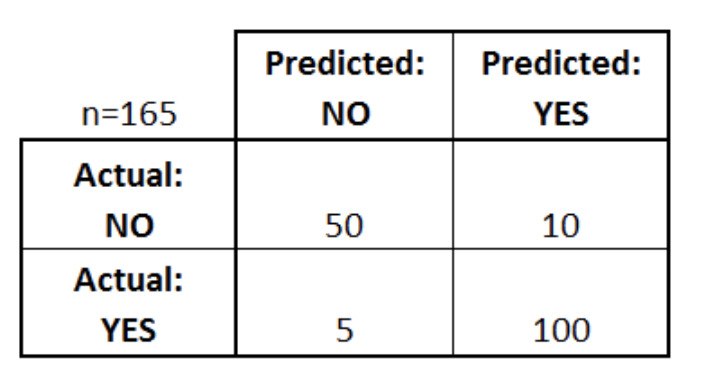

What can we learn from this matrix?

* There are two possible predicted classes: "yes" and "no". If we were predicting the presence of a disease, for example, "yes" would mean they have the disease, and "no" would mean they don't have the disease.
* The classifier made a total of 165 predictions (e.g., 165 patients were being tested for the presence of that disease).
* Out of those 165 cases, the classifier predicted "yes" 110 times, and "no" 55 times.
* In reality, 105 patients in the sample have the disease, and 60 patients do not.

Let's now define the most basic terms, which are whole numbers (not rates):

* true positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
* true negatives (TN): We predicted no, and they don't have the disease.
* false positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
* false negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

I've added these terms to the confusion matrix, and also added the row and column totals:

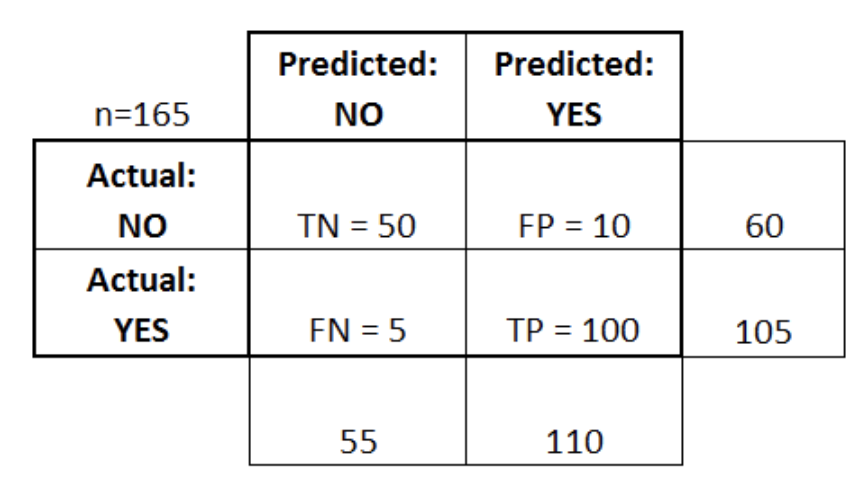

This is a list of rates that are often computed from a confusion matrix for a binary classifier:

* Accuracy: Overall, how often is the classifier correct?
  * (TP+TN)/total = (100+50)/165 = 0.91
* Misclassification Rate: Overall, how often is it wrong?
  * (FP+FN)/total = (10+5)/165 = 0.09
  * equivalent to 1 minus Accuracy
  * also known as "Error Rate"
* True Positive Rate: When it's actually yes, how often does it predict yes?
  * TP/actual yes = 100/105 = 0.95
  * also known as "Sensitivity" or "Recall"
* False Positive Rate: When it's actually no, how often does it predict yes?
  * FP/actual no = 10/60 = 0.17
  * Specificity: When it's actually no, how often does it predict no?
* TN/actual no = 50/60 = 0.83
  * equivalent to 1 minus False Positive Rate
* Precision: When it predicts yes, how often is it correct?
  * TP/predicted yes = 100/110 = 0.91
* Prevalence: How often does the yes condition actually occur in our sample?
  * actual yes/total = 105/165 = 0.64

## Example confusion matrix for the Iris Data

In [12]:
#Please do NOT run these cells
#See labs for this unit for more details of this

from sklearn.metrics import confusion_matrix  

cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_test = confusion_matrix(y_test, preds_test).astype(np.float32)
cm_test /= cm_test.sum(axis=1)[:, np.newaxis]

NameError: name 'y_train' is not defined

Visualize them

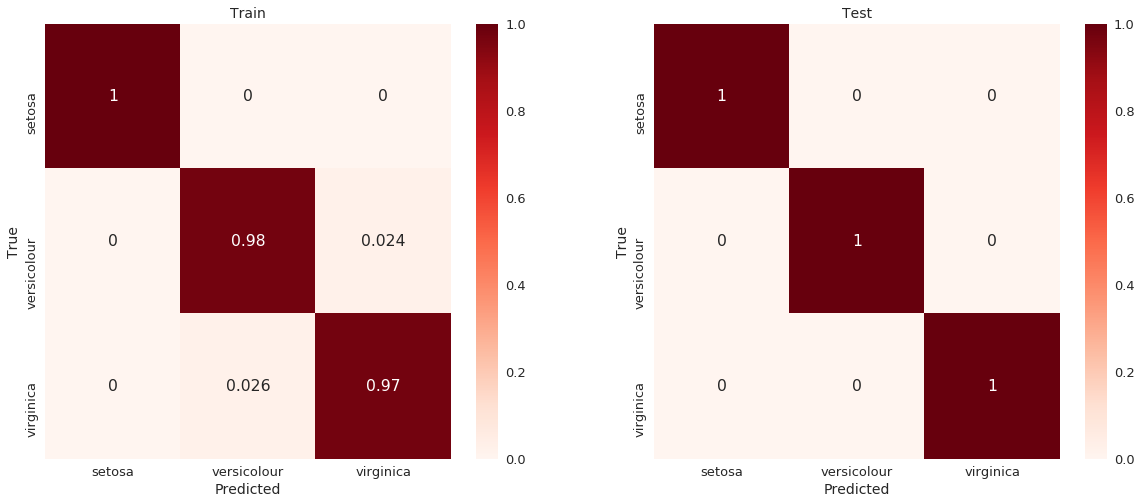

In [22]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_test, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

Looking at the confusions matrices for training, setosa perfectly separates from two other classes. In the test confusion matrize we see perfect classification (very unusual and suspect in the real world)

# Task:  20 class text classifier
Using the gridsearch pipeline presented in the previous section, please adapt it to get your best configuration using cross fold validation on all 20 classes from the 20 newsgroups dataset. Here are some hyperparamters to consider but dont limit your self to these:

* penalty
* number of terms
* types of ngrams
* linear classifier
* TDIDF


Have fun! Please report your best score and configuration. And discuss your confusion matrix analysis for the best configuration.


In [22]:
# This code is adopted  and has been modified from 
#
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
%matplotlib inline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################

categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()


Automatically created module for IPython interactive environment
Loading 20 newsgroups dataset for categories:
None
11314 documents
20 categories



** In order to decrease parameter tuning time, 10% data was selected, but with 20 categories.**

In [27]:
X_train, _, y_train, _ = train_test_split(data.data, data.target, stratify=data.target, train_size=0.1, random_state=42)

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [38]:

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),  #http://scikit-learn.org/stable/modules/feature_extraction.html
    ('tfidf', TfidfTransformer()), #ignore for now
    ('clf', SGDClassifier(loss='log', max_iter=5)),  #let's use logistic regression
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = { #listed in the form of "step__parameter", e.g, clf__penalty
    'vect__max_df': (0.5,1.0),
    'vect__max_features': (None, 500,10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams (single words) or bigrams (or sequence of words of length 2)
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2', 'elasticnet'),
    #'clf__penalty': ('l1', 'l2', 'elasticnet'),
    #'clf__loss': ('log', 'hinge'),  #hinge linear SVM
    #'clf__n_iter': (10, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    #print("grid_search.cv_results_", grid_search.cv_results_)
    #estimator : estimator object. This is assumed to implement the scikit-learn estimator interface.  
    #            Either estimator needs to provide a score function, or scoring must be passed.
    #Accuracy is the default for classification; feel free to change this to precision, recall, fbeta
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l1', 'l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 1.0),
 'vect__max_features': (None, 500, 10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 12.2min finished


done in 730.790s

Best score: 0.771
Best parameters set:
	clf__alpha: 1e-05
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 1.0
	vect__max_features: None
	vect__ngram_range: (1, 1)


In [53]:
model = grid_search.best_estimator_ 
preds_train=model.predict(X_train)
acc= accuracy_score(y_train, preds_train)
acc

1.0

** The confusion matrix for training data, all is 1.**

Text(0.5,1,'Train')

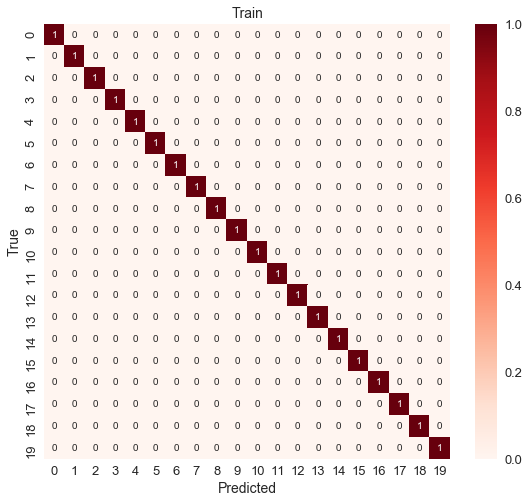

In [54]:

from sklearn.metrics import confusion_matrix  

cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
#g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)


In [45]:
#obtain test data, and make prediction on test data via best model
data = fetch_20newsgroups(subset='test',categories=categories)
model = grid_search.best_estimator_ 
preds_test=model.predict(data.data)

acc= accuracy_score(data.target, preds_test)
acc

0.7261019649495486

** Test data prediction with best model,below is confusion matrix for test data. The accuracy in the corner is a little bit lower than the accuracy in the center. In other words, true class 0,1,2,3 and 19,18,17 are more easily to be predicted into other class. for example, some true class 19 is easilty to be predicted as class 0**

Text(0.5,1,'Test')

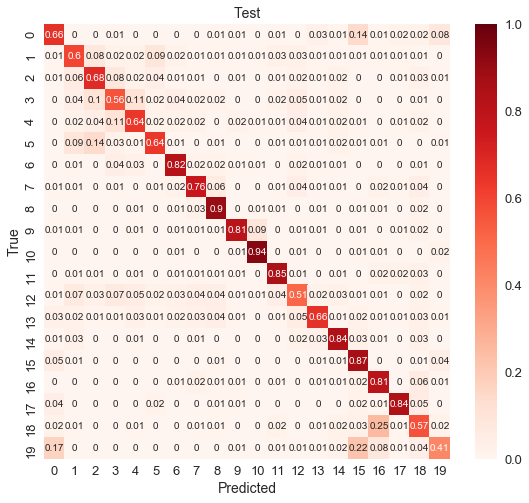

In [52]:
from sklearn.metrics import confusion_matrix  

cm_test = confusion_matrix(data.target, preds_test).astype(np.float32)
cm_test /= cm_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20, 8))
class_labels=data.target_names
plt.subplot(121)
g = sns.heatmap(np.round(cm_test,2), vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
#g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14)

# Task: Explore LASSO Logistic Regression
Model the CIFAR-10 dataset using LASSO Logistic Regression (l1 penalty term). Explore different values $\text{C}$ is the inverse regularization constant which is $\text{C} = \frac{1}{\lambda}$ that are listed here : {C=1.0, C=10.0, C=100.0, C=1000.0, C=10000.0}

Please reports your experimental results using the `results` table. Add one more column for reporting the number of zero coefficients after training. Recall, LASSO Logistic Regression can be useful in doing feature selection!   

NOTE: the coefficient of the learnt model, `model_lr_sklearn`, are available via `model_lr_sklearn.coef_`

`coef_ : array, shape (1, n_features) or (n_classes, n_features)

Coefficient of the features in the decision function.

coef_ is of shape (1, n_features) when the given problem is binary.`

 

In [18]:
#Display the results table with your experiments
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#Standard scaling before training
scl= StandardScaler()
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)
results = pd.DataFrame(columns=["Model Description","C","Test Accuracy", "#of Zero Coefficients"])
#Explore different C
for c in (1.0,10.0,100.0,1000.0,10000.0):
    model_lr=LogisticRegression(penalty='l1',C=c)  #let's use logistic regression
    model_lr.fit(X_train_std, y_train)
    preds_test=model_lr.predict(X_test_std)
    #test accuracy
    acc=accuracy_score( preds_test,y_test)
    #average number of zero coefficient per class
    avgzero=np.sum(model_lr.coef_==0)/model_lr.coef_.shape[0]
    #append results in table
    results.loc[len(results)] = ["LR Sklearn",c, np.round(acc, 3), np.round(avgzero, 0)]
results

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Model Description,C,Test Accuracy,#of Zero Coefficients
0,LR Sklearn,1.0,0.30,2933.0
1,LR Sklearn,10.0,0.31,2897.0
2,LR Sklearn,100.0,0.29,2802.0
3,LR Sklearn,1000.0,0.29,2299.0
4,LR Sklearn,10000.0,0.24,385.0


** And another way to do Lasso with kfold cross validation**

In [13]:
#load data
X=X_train
y=y_train

In [21]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_idx = list(cv.split(X, y))
results = pd.DataFrame(columns=["Model Description","C","Test Accuracy", "#of Zero Coefficients"])
for c in (1.0,10.0,100.0,1000.0,10000.0):
    acc = None
    coef_avg = None
    for train_idx, test_idx in cv_idx:
        # split
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # create logistic regression pipeline
        model = Pipeline([('scaler', MinMaxScaler()),
                          ('classifier', LogisticRegression(penalty='l1',C=c))])

        # fit
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # evaluate
        if acc is None:
            acc = accuracy_score(y_test, y_pred)
            coef_avg = np.sum(model.named_steps['classifier'].coef_==0)/model.named_steps['classifier'].coef_.shape[0]
        else:
            acc += accuracy_score(y_test, y_pred)
            coef_avg += np.sum(model.named_steps['classifier'].coef_==0)/model.named_steps['classifier'].coef_.shape[0]
    # take the average value across all folds
    acc /= cv.n_splits
    coef_avg /= cv.n_splits
    #append results in table
    results.loc[len(results)] = ["LR Sklearn",c, np.round(acc, 3), np.round( coef_avg, 0)]
results

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hjiang\AppData\Local\Continuum\anaconda

,Model Description,C,Test Accuracy,#of Zero Coefficients
0,LR Sklearn,1.0,0.332,2609.0
1,LR Sklearn,10.0,0.254,1838.0
2,LR Sklearn,100.0,0.239,788.0
3,LR Sklearn,1000.0,0.240,22.0
4,LR Sklearn,10000.0,0.240,0.0


** Let's explore what is the result from GridSearchCV**

In [28]:
#load data first before run the following code
from sklearn.model_selection import GridSearchCV

pipe_model = Pipeline([('scaler', MinMaxScaler()),
                  ('classifier', LogisticRegression())
                 ])

param_grid = {'classifier__penalty':['l1'], 
              'classifier__C': [1, 10, 100, 1000, 10000]             }

gs = GridSearchCV(pipe_model, param_grid, cv=5, verbose=2,scoring="accuracy")
gs.fit(X_train, y_train)
#cvres = grid_search.cv_results_
#for acc, coef in zip(cvres["mean_test_score"], cvres["params"]):


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] classifier__C=1, classifier__penalty=l1 .........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] .......... classifier__C=1, classifier__penalty=l1, total=  34.8s
[CV] classifier__C=1, classifier__penalty=l1 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.0s remaining:    0.0s
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] .......... classifier__C=1, classifier__penalty=l1, total=  34.7s
[CV] classifier__C=1, classifier__penalty=l1 .........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] .......... classifier__C=1, classifier__penalty=l1, total=  34.0s
[CV] classifier__C=1, classifier__penalty=l1 .........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] .......... classifier__C=1, classifier__penalty=l1, total=  35.4s
[CV] classifier__C=1, classifier__penalty=l1 .........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] .......... classifier__C=1, classifier__penalty=l1, total=  35.2s
[CV] classifier__C=10, classifier__penalty=l1 ........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ......... classifier__C=10, classifier__penalty=l1, total=10.1min
[CV] classifier__C=10, classifier__penalty=l1 ........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ......... classifier__C=10, classifier__penalty=l1, total=10.0min
[CV] classifier__C=10, classifier__penalty=l1 ........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ......... classifier__C=10, classifier__penalty=l1, total= 9.9min
[CV] classifier__C=10, classifier__penalty=l1 ........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ......... classifier__C=10, classifier__penalty=l1, total= 9.7min
[CV] classifier__C=10, classifier__penalty=l1 ........................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ......... classifier__C=10, classifier__penalty=l1, total= 9.8min
[CV] classifier__C=100, classifier__penalty=l1 .......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ........ classifier__C=100, classifier__penalty=l1, total=16.8min
[CV] classifier__C=100, classifier__penalty=l1 .......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ........ classifier__C=100, classifier__penalty=l1, total=16.8min
[CV] classifier__C=100, classifier__penalty=l1 .......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ........ classifier__C=100, classifier__penalty=l1, total=18.4min
[CV] classifier__C=100, classifier__penalty=l1 .......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ........ classifier__C=100, classifier__penalty=l1, total=18.2min
[CV] classifier__C=100, classifier__penalty=l1 .......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ........ classifier__C=100, classifier__penalty=l1, total=18.6min
[CV] classifier__C=1000, classifier__penalty=l1 ......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ....... classifier__C=1000, classifier__penalty=l1, total=20.0min
[CV] classifier__C=1000, classifier__penalty=l1 ......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ....... classifier__C=1000, classifier__penalty=l1, total=19.7min
[CV] classifier__C=1000, classifier__penalty=l1 ......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ....... classifier__C=1000, classifier__penalty=l1, total=20.1min
[CV] classifier__C=1000, classifier__penalty=l1 ......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ....... classifier__C=1000, classifier__penalty=l1, total=19.7min
[CV] classifier__C=1000, classifier__penalty=l1 ......................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ....... classifier__C=1000, classifier__penalty=l1, total=19.3min
[CV] classifier__C=10000, classifier__penalty=l1 .....................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ...... classifier__C=10000, classifier__penalty=l1, total=20.8min
[CV] classifier__C=10000, classifier__penalty=l1 .....................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ...... classifier__C=10000, classifier__penalty=l1, total=20.3min
[CV] classifier__C=10000, classifier__penalty=l1 .....................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ...... classifier__C=10000, classifier__penalty=l1, total=17.9min
[CV] classifier__C=10000, classifier__penalty=l1 .....................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ...... classifier__C=10000, classifier__penalty=l1, total=16.9min
[CV] classifier__C=10000, classifier__penalty=l1 .....................


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[CV] ...... classifier__C=10000, classifier__penalty=l1, total=17.3min


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 333.4min finished
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__penalty': ['l1'], 'classifier__C': [1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [36]:
coef_best=gs.best_estimator_.named_steps['classifier'].coef_
avgzero=np.sum(coef_best==0)/coef_best.shape[0]
np.round(avgzero,0)

2546.0

In [32]:
# best grid search parameters
gs.best_params_

{'classifier__C': 1, 'classifier__penalty': 'l1'}

**The result is similiar as the above kfold cross validation**

# TASK Homegrown implementation of Logistic Regression [OPTIONAL]

Below is a homegrown implementation of Logistic Regression. In this class  we added an ability to trace validation metrics.

In [15]:
class LogisticRegressionHomegrown(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Logistic Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "acc": [], 
                        "val_cost":[], 
                        "val_acc": []}
        
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        n = X.shape[0]
        
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        
        # transform scores to probabilities
        # softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # error
        probs[range(n),y] -= 1
        
        # gradient
        gradient = np.dot(X.T, probs) / n
        
        return gradient
    
    def _gd(self, X, y, max_iter, alpha, X_val, y_val):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        for i in range(max_iter):
            
            metrics = self.score(X, y)
            self.history["cost"].append(metrics["cost"])
            self.history["acc"].append(metrics["acc"])
            
            if X_val is not None:
                metrics_val = self.score(X_val, y_val)
                self.history["val_cost"].append(metrics_val["cost"])
                self.history["val_acc"].append(metrics_val["acc"])

            # calculate gradient
            grad = self._grad(X, y)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000, alpha=0.05, val_data=None):
        """
        Public API to fit Logistic regression model
        
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], len(np.unique(y)))
        
        # do full gradient descent
        self._gd(X, y, max_iter, alpha, X_val, y_val)
        
        # get final weigths and bias
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        
    def score(self, X, y):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """
        # number of training samples
        n = X.shape[0]
        
        # get scores
        scores = self._predict_raw(X)
        
        # trasnform scores to probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # logloss per each example
        corect_logprobs = -np.log(probs[range(n),y])
        
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / n
        
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)
        
        # final metrics
        metrics = {"acc": acc, "cost": data_loss}
        
        return metrics
        
    def _predict_raw(self, X):
        """
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        return scores
    
    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        # get scores for each class
        scores = self._predict_raw(X)
        # choose class with maximum score
        pred = np.argmax(scores, axis=1)
        return pred

**Do not forget** to scale data before using this class. It is crucial.

In [70]:
if np.max(X_train) > 4.:
    X_train_sc = X_train.astype(np.float32) / 255.
if np.max(X_test) > 4.:
    X_test_sc = X_test.astype(np.float32) / 255.

Defining a model

In [17]:
model_lr_homegrown = LogisticRegressionHomegrown()

Fitting example

In [21]:
model_lr_homegrown.fit(X_train_sc, y_train, max_iter=10, alpha=0.05)

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in log
C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


And we come up with all the $\text{nan's}$ for objective function

In [22]:
model_lr_homegrown.history["cost"]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

And accuracy also does not change

In [23]:
model_lr_homegrown.history["acc"]

[0.080000000000000002,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001]

## Task: Softmax Numerical Stability
What can be causing this kind of problem ("NaN")? (Hint: see the lecture slides "Numerical Stability for softmax function")
* Please fix this problem
* Next section has some background to help shed some light

There is exp overflow,which caused this kind of problem("NaN")-data out of bounds.
So we can use adjusted data to avoid data overflow by subtracting the max score in the row

### Working with np.max and matrices
Explore the code in the following section first to see why/how!

In [138]:
## Working with np.max, softmax, and matrices
import numpy as np

# For more info on np.max check the following link :
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.amax.html

#GOAL: On a per row basis: Substract  max of that row from each element in that row
#ATTEMPT #1: 
f = np.array([[1, 2, 3],[4, 5, 6]])
f1 = f - np.max(f)
# this does not work as expected - as np.max(f) returns the overall max 
print ("Is this correct?")
print ("Adjusted data1", f1)

# take max of f per row 
#ATTEMPT #2: pay attention to axis and keepdims
f2 = f - np.max(f, axis=1, keepdims=True)
print ("Adjusted data2", f2)


#Normalised score to sum to 1
f=([1,3,6], [2,4,6])
p = f / np.sum(f,axis=1, keepdims=True)
print ("Normalised score...\n", p)

# The following data will not work with for the softmax calculation
# out of bounds
perpendicularDistances = np.array([[123, 234, 345],[444, 555, 999]])
probs = np.exp(perpendicularDistances) / np.sum(np.exp(perpendicularDistances), axis=1, keepdims=True)
print("This produces NaNs: (see SECOND ROW) \n", probs)
# need to use adjusted data 
perpendicularDistances -= np.max(perpendicularDistances, axis=1, keepdims=True)
# trasnform scores to probabilities
exp_scores = np.exp(perpendicularDistances)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
print ("Probabilities...\n", probs)

Is this correct?
Adjusted data1 [[-5 -4 -3]
 [-2 -1  0]]
Adjusted data2 [[-2 -1  0]
 [-2 -1  0]]
Normalised score...
 [[ 0.1         0.3         0.6       ]
 [ 0.16666667  0.33333333  0.5       ]]
This produces NaNs: (see SECOND ROW) 
 [[  3.86033521e-97   6.21315959e-49   1.00000000e+00]
 [  0.00000000e+00   0.00000000e+00              nan]]
Probabilities...
 [[  3.86033521e-097   6.21315959e-049   1.00000000e+000]
 [  9.25896716e-242   1.49021879e-193   1.00000000e+000]]


C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [18]:
class FixedLogisticRegressionHomegrown(LogisticRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(FixedLogisticRegressionHomegrown, self).__init__()
        
    #==================================================#
    #               Place your code here               #
    #     Redefine a method which causes the error     #
    #               Hint: only one method              #
    #==================================================#
    def _predict_raw(self, X):
        """
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        #scores=np.clip(scores,-250,250)
        scores-=np.max(scores,axis=1,keepdims=True)
        
        return scores
        #return 1./(1.+np.exp(-np.clip(scores,-250,250)))

Defining a model

In [19]:
model_lr_homegrown_fixed = FixedLogisticRegressionHomegrown()

Fitting example

In [20]:
model_lr_homegrown_fixed.fit(X_train_sc, y_train, max_iter=2000, alpha=0.05, val_data=(X_test_sc, y_test))
#model_lr_homegrown_fixed.fit(X_train_sc, y_train, max_iter=2000, alpha=0.05)

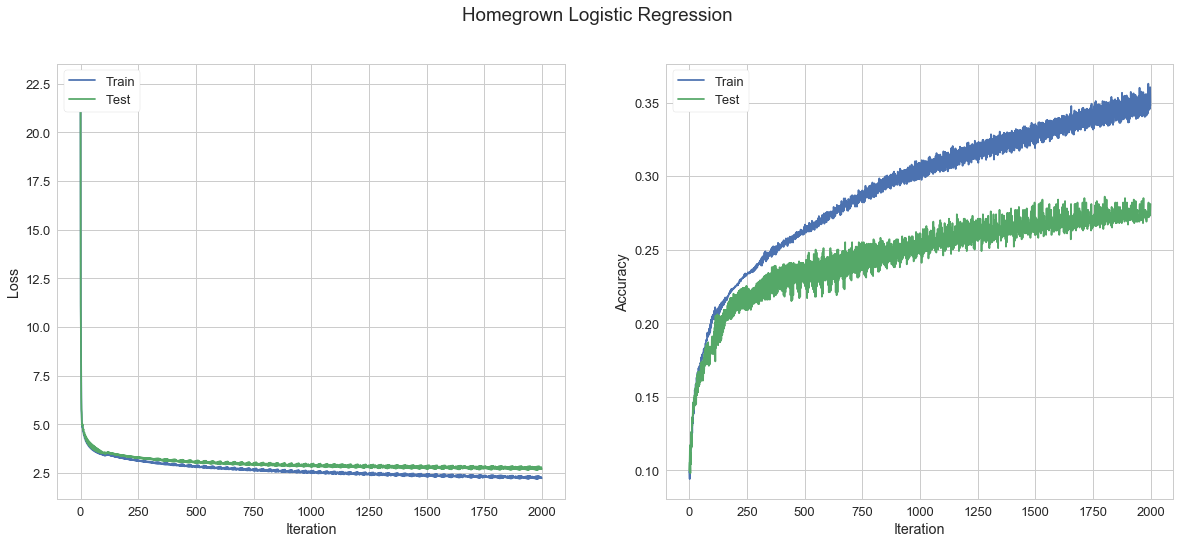

In [21]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Logistic Regression")
plt.subplot(121)
plt.plot(model_lr_homegrown_fixed.history["cost"], label="Train")
plt.plot(model_lr_homegrown_fixed.history["val_cost"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.subplot(122)
plt.plot(model_lr_homegrown_fixed.history["acc"], label="Train")
plt.plot(model_lr_homegrown_fixed.history["val_acc"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

Prediction

In [22]:
y_pred_test = model_lr_homegrown_fixed.predict(X_test_sc)

Accuracy

In [23]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [24]:
results = pd.DataFrame(columns=["Model Description","C","Test Accuracy", "Extra field"])
results.loc[len(results)] = ["LR Homegrown Fix 1", "C",np.round(acc, 3),"........"] #please update as needed
results

,Model Description,C,Test Accuracy,Extra field
0,LR Homegrown Fix 1,C,0.274,........


## Task: improve by tuning training algo.
Look at the plots obtained at the end of task 1 (it fluctuates a lot). This behaviour is very common to stochastic gradient descent. But here we are using full GD. What could be causing this problem? (*Hint*: a hyperparameter of the training algorithm)
* Describe what's going on on the plots that you got
* Try to fix it (*Hint*: you do NOT need to change the class implemented before)

P.S.
Test accuracy before this fix should be about 26%. This should jump to  31% after. 

**I tried to add L2 regulation into home logistic regression model by redefine _grad function. but unfortunately, there is no any accuracy improvement, and there is extra error!**

**Then I tried to prune hyperparameters(alpha and max iteration),there are some improvements for some parameters.
The highest score I got is 32.2% with alpha=0.0005 and max_iteration=2000.**

In [25]:
class FixedLogisticRegressionHomegrownwithL2(FixedLogisticRegressionHomegrown):
    
    def __init__(self,landa):
        # call the constructor of the parent class
        super(FixedLogisticRegressionHomegrownwithL2, self).__init__()
        self.landa=landa

    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        n = X.shape[0]
        
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        
        # transform scores to probabilities
        # softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # error
        probs[range(n),y] -= 1
        
        # gradient
        gradient = np.dot(X.T, probs) / n
        #gradient-=self.landa*self.coef_
        gradient=gradient-self.landa*self._theta
        
        
        return gradient

In [26]:
model_lr_homegrown_fixed_l2 = FixedLogisticRegressionHomegrownwithL2(0.05)

In [29]:
results = pd.DataFrame(columns=["Model Description","Test Accuracy"])
model_lr_homegrown_fixed_l2.fit(X_train_sc, y_train, max_iter=1000, alpha=0.005,val_data=(X_test_sc, y_test))
y_pred_test = model_lr_homegrown_fixed_l2.predict(X_test_sc)
acc = accuracy_score(y_test, y_pred_test)
results.loc[len(results)] = ["LR Homegrown Fix 1",np.round(acc, 3)] #please update as needed
results

C:\Users\hjiang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in log


,Model Description,Test Accuracy
0,LR Homegrown Fix 1,0.237


In [31]:
#==================================================#
#               Place your code here               #
#==================================================#
model_lr_homegrown_fixed = FixedLogisticRegressionHomegrown()
results = pd.DataFrame(columns=["Model Description","landa","alpha","Test Accuracy"])
for maxiteration in (1000,2000,3000):
    for alpha in (0.0005,0.005,0.05,0.5,0.1):
        model_lr_homegrown_fixed.fit(X_train_sc, y_train, max_iter=maxiteration, alpha=alpha,val_data=(X_test_sc, y_test))
        y_pred_test = model_lr_homegrown_fixed.predict(X_test_sc)
        acc = accuracy_score(y_test, y_pred_test)
        results.loc[len(results)] = ["LR Homegrown Fix 1",maxiteration,alpha ,np.round(acc, 3)] #please update as needed
results

,Model Description,landa,alpha,Test Accuracy
0,LR Homegrown Fix 1,1000,0.0005,0.121
1,LR Homegrown Fix 1,1000,0.0050,0.202
2,LR Homegrown Fix 1,1000,0.0500,0.246
3,LR Homegrown Fix 1,1000,0.5000,0.281
4,LR Homegrown Fix 1,1000,0.1000,0.297
5,LR Homegrown Fix 1,2000,0.0005,0.322
6,LR Homegrown Fix 1,2000,0.0050,0.319
7,LR Homegrown Fix 1,2000,0.0500,0.308
8,LR Homegrown Fix 1,2000,0.5000,0.238
9,LR Homegrown Fix 1,2000,0.1000,0.282


** Note: I was able to get about 31% test set accuracy with all the fixes and tunes.**
**The highest score I got is 32.2% with alpha=0.0005 and max_iteration=2000.**

## Task : Visualize the  weight vectors
Visualize the  weight vectors (like images) for each class for both Sklearn learnt model and best homegrown learnt model. Can you see any class patterns? How long did it take to run? in both cases?

### Task : Use all training data and visualize the  weight vectors
Try to use all the training data to learn a classification model  Sklearn and then visual the resulting weight vectors. Notice any differences. How long did it take to run?

In [ ]:
#==================================================#
#               Place your code here               #
#   Hint: use show_pic() function defined above    #
#==================================================#

In [56]:
from time import time

### 10% training data

#### Sklearn logistic regression model with L1 and L2 regulation

In [57]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(penalty="l2",C=10)

#train linear classification model
t0=time()
lr.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))
weights=lr.coef_

done in 720.963s


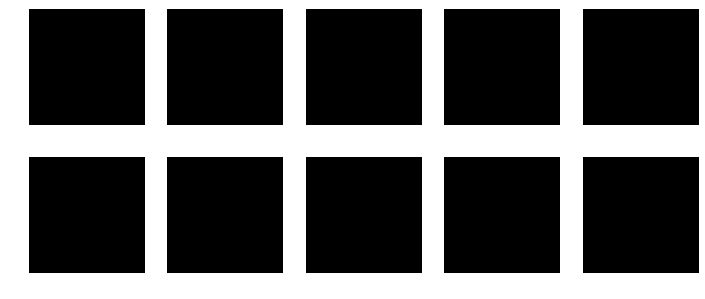

In [58]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(weights[i])

**They are the same for 10 classes. No pattern can be detected from above.**

In [59]:
from sklearn.linear_model import LogisticRegression
lr_l1=LogisticRegression(penalty="l1",C=10)

#train linear classification model
t0=time()
lr_l1.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))
weights_l1=lr_l1.coef_

done in 2913.751s


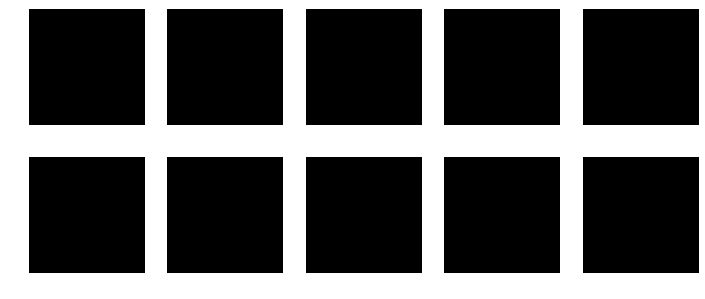

In [60]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(weights_l1[i])

#### Home logistic regression model

In [61]:
t0=time()
model_lr_homegrown_fixed.fit(X_train_sc, y_train, max_iter=2000, alpha=0.0005,val_data=(X_test_sc, y_test))
print("done in %0.3fs" % (time() - t0))

done in 159.945s


In [62]:
weights_home=model_lr_homegrown_fixed.coef_
weights_home.shape

(3072, 10)

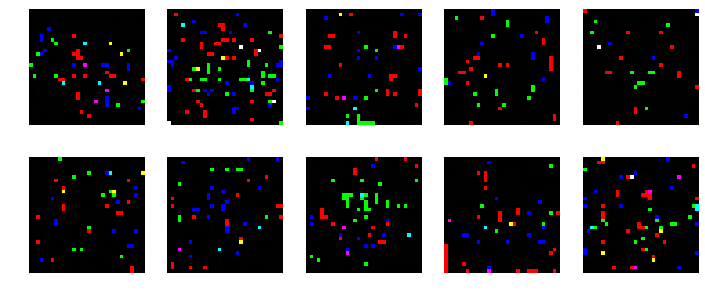

In [63]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(weights_home.T[i])

The interesting thing is that I can see some class patterns from weights vectors resulting from home logistic regression training model

### All training data

In [71]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train size_sc:", X_train_sc.shape[0])
print("Test size_sc:", X_test_sc.shape[0])

Train size: 50000
Test size: 10000
Train size_sc: 50000
Test size_sc: 10000


#### Sklearn logistic regression model

done in 22632.411s


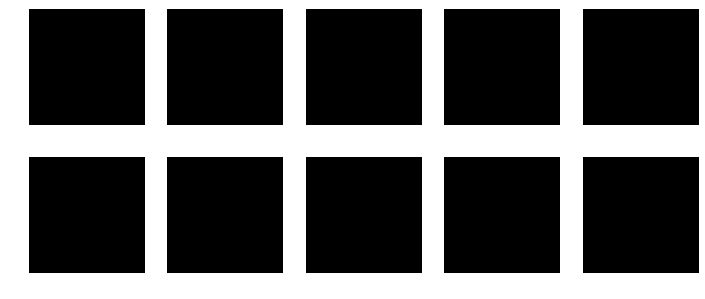

In [73]:
from sklearn.linear_model import LogisticRegression
lr_all=LogisticRegression()

#train linear classification model
t0=time()
lr_all.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))
weights_all=lr_all.coef_
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(weights_all[i])

#### Home logistic regression model

done in 1569.402s


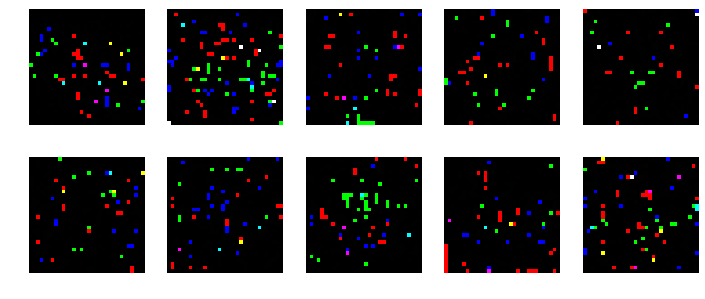

In [72]:
t0=time()
model_lr_homegrown_fixed.fit(X_train_sc, y_train, max_iter=2000, alpha=0.0005,val_data=(X_test_sc, y_test))
print("done in %0.3fs" % (time() - t0))
weights_home=model_lr_homegrown_fixed.coef_
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(weights_home.T[i])

## T-SNE dimensionality reduction.

See [this](https://www.dropbox.com/s/q0lrqtphxh5j4uv/6-Mapping_Representations-tSNE-visualize-DL-Model-Layers.ipynb?dl=0) notebook and also search materials on the internet (e.g. [this](http://distill.pub/2016/misread-tsne/) one) on T-SNE (t-Distributed Stochastic Neighbor Embedding).

Perform this embedding (there is [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation) on first three classes and 500 examples per each of them (this is done ro reduce the execution time)

In [91]:
#get first three classes and 500 examples per each of them 
data_tsne=pd.DataFrame(X_train)
data_tsne["target"]=y_train
data_tsne=data_tsne[data_tsne["target"]<3]
y_tsne=data_tsne["target"]
X_tsne=data_tsne.drop(['target'],axis=1)


,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
5,255,253,253,253,253,253,253,253,253,253,...,247,249,251,250,251,250,249,251,251,254
6,146,144,140,142,149,130,80,50,45,41,...,193,205,200,193,168,129,99,76,75,99
7,242,237,242,243,243,244,244,244,244,243,...,2,2,3,15,35,62,16,3,20,45
9,110,98,92,95,112,114,107,122,122,116,...,164,165,168,173,178,178,180,178,179,184
12,88,91,91,80,85,77,73,74,84,84,...,54,65,52,54,75,50,68,77,50,80


In [97]:
unique_train = np.unique(y_tsne, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500), ('automobile', 500), ('bird', 500)]

In [94]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,random_state=0)
#project the data in 2D
X_2d=tsne.fit_transform(X_tsne)

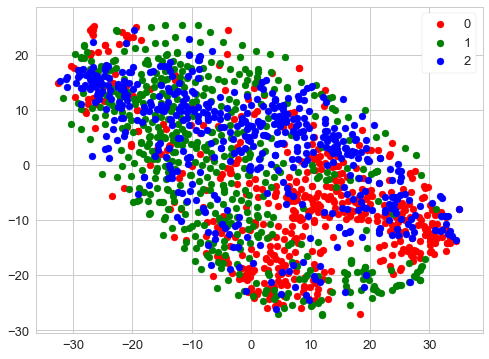

In [96]:
#visualize the data
target_ids=np.unique(y_tsne)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
#colors=("r","g","b","c","m","y","k","w","orange","purple")
colors=("r","g","b")
for i,c,label in zip(target_ids,colors,target_ids):
    plt.scatter(X_2d[y_tsne==i,0],X_2d[y_tsne==i,1],c=c,label=label)
plt.legend()
plt.show()